In [23]:
import os
import nltk
import string
from pickle import dump, HIGHEST_PROTOCOL
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, make_scorer, f1_score

In [3]:
print(tf.__version__)

2.2.0


# Loading the data 

In [4]:
df = pd.read_csv('spam_dataset_extended.csv', encoding='latin-1')

In [5]:
df.head()

v1  ... Unnamed: 37
0   ham  ...         NaN
1   ham  ...         NaN
2  spam  ...         NaN
3   ham  ...         NaN
4   ham  ...         NaN

[5 rows x 38 columns]

In [6]:
df = df[['v2','v1']]
df = df.rename(columns={'v2':'Message', 'v1':'outcome'})
df.head()

Message outcome
0  Go until jurong point, crazy.. Available only ...     ham
1                      Ok lar... Joking wif u oni...     ham
2  Free entry in 2 a wkly comp to win FA Cup fina...    spam
3  U dun say so early hor... U c already then say...     ham
4  Nah I don't think he goes to usf, he lives aro...     ham

In [7]:
# check null values
df.isnull().sum()

Message    0
outcome    0
dtype: int64

In [8]:
# Shuffles the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
data = df.copy(deep=True)

#Exploratory Data Analysis:

In [10]:
data.shape

(6115, 2)

In [11]:
print('Percent of Non Spams: {} %'.format(int((data['outcome'].value_counts()[0] / data['outcome'].count())*100)))
print('Percent of Spams: {} %'.format(int((data['outcome'].value_counts()[1] / data['outcome'].count())*100)))

Percent of Non Spams: 80 %
Percent of Spams: 19 %


As we can see we have a highly imbalanced dataset

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6115 entries, 0 to 6114
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  6115 non-null   object
 1   outcome  6115 non-null   object
dtypes: object(2)
memory usage: 95.7+ KB


As we have both the feilds as Categorical variables. The 'Outcome' variable is an binary feature column which represent whether 

In [13]:
data['outcome'] = data['outcome'].map({'ham':0,'spam':1})
data.head()

Message  outcome
0                                                \ER        0
1  Fuck cedar key and fuck her (come over anyway ...        0
2                                        Anything...        0
3  Hi I'm sue. I am 20 years old and work as a la...        1
4                             Hmm well, night night         0

In [14]:
print ('Corpus of {} texts'.format(data.shape[0]))

Corpus of 6115 texts


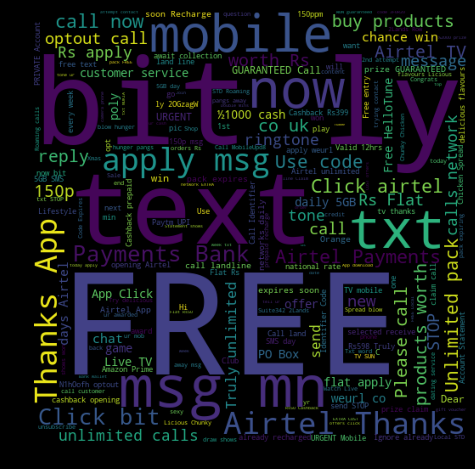

In [15]:
spam_words = ' '.join(list(data[data['outcome'] == 1]['Message']))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize= (10,8), facecolor='k')
plt.imshow(spam_wc)
plt.show()

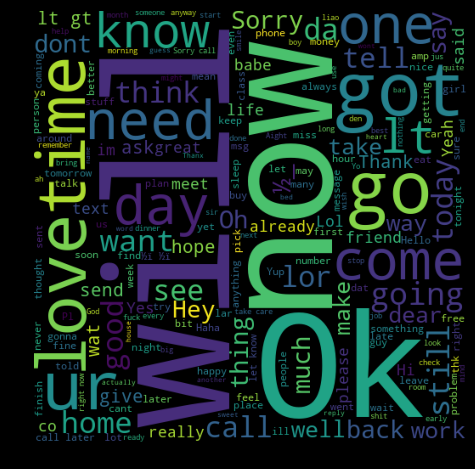

In [16]:
ham_words = ' '.join(list(data[data['outcome'] == 0]['Message']))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize= (10,8), facecolor='k')
plt.imshow(ham_wc)
plt.show()

# Data Split:

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(data['Message'], data['outcome'],test_size=0.20, random_state=42)

In [18]:
print(f'Number of records in train: {len(X_train)}')
print(f'Number of records in test: {len(X_test)}')

Number of records in train: 4892
Number of records in test: 1223


In [19]:
print('Shape of X_Train: {}, Y_Train: {}'.format(X_train.shape, Y_train.shape))
print('Shape of X_Test: {}, Y_Test: {} '.format(X_test.shape, Y_test.shape))

Shape of X_Train: (4892,), Y_Train: (4892,)
Shape of X_Test: (1223,), Y_Test: (1223,) 


# Preprocessing:

In [20]:
# Tokenization:

max_words = 1000
max_len = 150
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
seq = tokenizer.texts_to_sequences(X_train)
seq_matrix = sequence.pad_sequences(seq, maxlen = max_len)

In [25]:
# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    dump(tokenizer, handle, protocol=HIGHEST_PROTOCOL)

# Model Defination:

In [26]:
def RNN():
  inputs = Input(name='inputs', shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256)(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='outputlayer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs, outputs=layer)
  return model

In [27]:
logdir = os.path.join('/tmp/logs', datetime.datetime.now().strftime('%d%m%Y-%H%M%S'))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpointer = ModelCheckpoint(filepath='/content/spam_classifier.hdf5',verbose=1,save_best_only=True)

In [28]:
model = RNN()
model.summary()
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
outputlayer (Dense)          (None, 1)                 257   

# Training:

In [29]:
history = model.fit(seq_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001),tensorboard_callback,checkpointer])

Epoch 1/10
30/31 [============================>.] - ETA: 0s - loss: 0.5074 - accuracy: 0.7867
Epoch 00001: val_loss improved from inf to 0.33111, saving model to /content/spam_classifier.hdf5
31/31 [==============================] - 1s 31ms/step - loss: 0.5043 - accuracy: 0.7874 - val_loss: 0.3311 - val_accuracy: 0.8069
Epoch 2/10
29/31 [===========================>..] - ETA: 0s - loss: 0.1688 - accuracy: 0.9297
Epoch 00002: val_loss improved from 0.33111 to 0.08814, saving model to /content/spam_classifier.hdf5
31/31 [==============================] - 1s 16ms/step - loss: 0.1684 - accuracy: 0.9310 - val_loss: 0.0881 - val_accuracy: 0.9745
Epoch 3/10
29/31 [===========================>..] - ETA: 0s - loss: 0.0567 - accuracy: 0.9833
Epoch 00003: val_loss improved from 0.08814 to 0.06156, saving model to /content/spam_classifier.hdf5
31/31 [==============================] - 1s 16ms/step - loss: 0.0557 - accuracy: 0.9836 - val_loss: 0.0616 - val_accuracy: 0.9826
Epoch 4/10
29/31 [========

# Training Curves:

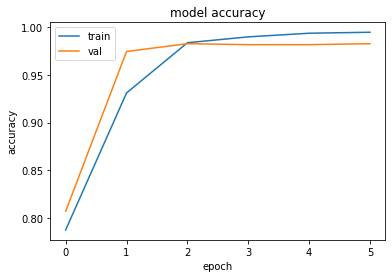

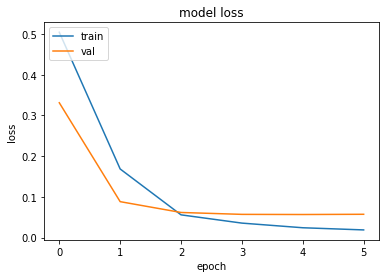

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Saving the model:

In [30]:
model.save('/content/spam_classifier.hdf5')

# Testing:

In [33]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_seq_matrix = sequence.pad_sequences(test_seq, maxlen = max_len)

In [34]:
acc = model.evaluate(test_seq_matrix,Y_test)

39/39 [==============================] - 0s 5ms/step - loss: 0.0515 - accuracy: 0.9861


In [35]:
print(f'Loss: {round(acc[0],2)}, Accuracy: {round(acc[1],2)}')

Loss: 0.05, Accuracy: 0.99


In [36]:
sentence = ['Hey!, Sorry I was in a meeting so couldnt text you back.']
txt = tokenizer.texts_to_sequences(sentence)
txt = sequence.pad_sequences(txt, maxlen = max_len)

prediction = model.predict(txt)
print(prediction[0][0])

0.0011991868


In [37]:
sentence = ['The value of Rupee just skyrocketed! Chicken Breast Boneless for Re 1* only!Order now before stocks run out Use code: INRONE']
txt = tokenizer.texts_to_sequences(sentence)
txt = sequence.pad_sequences(txt, maxlen = max_len)

prediction = model.predict(txt)
print(prediction[0][0])

0.9808801


The output is damn right!!

# TensorBoard:

In [38]:
%reload_ext tensorboard

In [39]:
%tensorboard --logdir /tmp/logs

<IPython.core.display.Javascript object>